In [1]:
import os
import time

import numpy as np
import tensorflow as tf
import keras
import keras.layers
import cv2

import matplotlib.pyplot as plt
import ipympl

import image_handler as handler
import test_data_generator as test

# Standard CV2 circle detection (Hough Circle)

In [ ]:
img = cv2.cvtColor(cv2.imread(os.path.join("testing_data", "image.png")), cv2.COLOR_BGR2GRAY)
output = img.copy()

circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=40, maxRadius=60)

if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    for (x, y, r) in circles:
        cv2.circle(output, center=(x, y), radius=r, color=(0, 255, 0), thickness=4)
        cv2.rectangle(output, pt1=(x-5, y-5), pt2=(x+5, y+5), color=(0, 128, 255), thickness=-1)
    
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].imshow(img, cmap='gray')
ax[1].imshow(output, cmap='gray')

# Test data

### Sample test data

In [ ]:
%matplotlib widget
img_shape = (200, 200, 3)
img, label = test.create_data_sample(10, img_shape[0], img_shape[1])

handler.show_sample(img, label)
print(img.shape, label.shape)

### Batch test data

In [ ]:
img_batch = []
label_batch = []

for idx in range(1):
    img, label  = test.create_data_sample(10, img_shape[0], img_shape[1])
    img_batch.append(img)
    label_batch.append(label)
    
img_batch = np.array(img_batch)
label_batch = np.array(label_batch)

print(img_batch.shape, label_batch.shape)
handler.show_batch(img_batch, label_batch)

# Real data

### Sample real data

In [2]:
img_shape = (187, 249, 3)

In [3]:
folder = "training_data"
# folder = os.path.join("output_data", "basic")

images = []
for file in os.listdir(folder):
    if file.endswith(".jpg"):
        images.append(file)

images = sorted(images)

t0_well0_10.jpg (0.514, 0.455, 0.14)
(187, 249, 1)


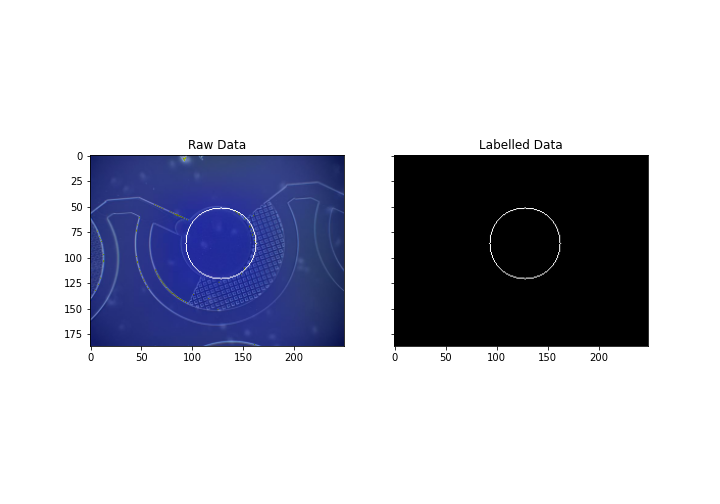

In [9]:
from droplet_labels import droplet_labels

i = 1

print(images[i], droplet_labels[images[i]])
raw, img, label = handler.load_image(
    os.path.join("training_data", images[i]),
    droplet_labels[images[i]],
    overlay=True,
    scale_percent=30
)

print(label.shape)

fig = handler.show_sample(img, label)
# plt.close("all")

In [ ]:
fig, ax = plt.subplots()

In [ ]:
# fig, ax = plt.subplots()
# ax.imshow(raw)
# fig.savefig(os.path.join("results", "real_data_raw.png"), dpi=300, bbox_inches='tight')

# fig.savefig(os.path.join("results", "real_data_processed.png"), dpi=300, bbox_inches='tight')
# plt.close("all")'

### Batch real data

In [ ]:
from droplet_labels import droplet_labels

folder = "training_data"
# folder = os.path.join("output_data", "basic")
img_batch, label_batch = handler.load_images_from_folder(folder, len(droplet_labels), droplet_labels, scale_percent=30)

print(img_batch.shape, label_batch.shape)
fig = handler.show_batch(img_batch, label_batch, idx=50)

img_batch = img_batch

# Convolutional Neural Network (CNN)

## 3 layer network

In [ ]:
model = keras.models.load_model("droplet_detection_model")

In [ ]:
inputs = keras.Input(shape=img_shape)

conv1 = keras.layers.Conv2D(16, 4, padding='same', activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=None)(inputs)
conv1 = keras.layers.BatchNormalization(momentum=0.99)(conv1)

conv2 = keras.layers.Conv2D(32, 4, padding='same', activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=None)(conv1)
conv2 = keras.layers.BatchNormalization(momentum=0.99)(conv2)

conv3 = keras.layers.Conv2D(16, 4, padding='same', activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=None)(conv2)
conv3 = keras.layers.BatchNormalization(momentum=0.99)(conv3)

outputs = keras.layers.Conv2D(1, 4, padding='same', activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=None)(conv3)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

## Define a reduced mean square loss function

## Compile CNN optimizer

In [ ]:
model.compile(optimizer="Adam", loss="mean_squared_error")

In [ ]:
t1 = time.time()
model.fit(img_batch, label_batch, batch_size=1000, epochs=1000, verbose=1)
print(f"Time taken = {int(time.time() - t1)} s")

# Visualize results

### Test data results

In [ ]:
img, label = test.test_batch(10, img_shape[0], img_shape[1])
pred = model.predict(img_batch)

fig = handler.show_result(img_batch, label_batch, pred)
# fig.savefig(os.path.join("results", "test_data_result.png"), dpi=300, bbox_inches='tight')

### Real data results

In [ ]:
%matplotlib widget
i = 34
images = sorted(os.listdir("training_data"))
img, label = handler.load_test_image(os.path.join("training_data", images[i]), droplet_labels[i])
pred = model.predict(img)

handler.show_result(img, label, pred)
# fig.savefig(os.path.join("results", "real_data_result.png"), dpi=300, bbox_inches='tight')

# Save model if training successful

In [ ]:
model.save('droplet_enhancement_model')